In [1]:
import os

os.environ["CUDA_DEVICE_ORDER"] = "0"

In [2]:
import torch

torch.cuda.empty_cache()

# 프레임 추출_예시

In [ ]:
import cv2
import numpy as np

# Video에서 프레임 추출
def extract_frames(video_path):
    cap = cv2.VideoCapture(video_path)
    frames = []
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.resize(frame, (64, 64))
        frames.append(frame)
    cap.release()
    return np.array(frames) / 255.0  # Normalize pixel values to [0, 1] range

video_path = './data/pose_est/origin_dataset/Subject_1/Fall/Sub1_01.mp4'
frames = extract_frames(video_path)
print(f"총 {len(frames)}개의 프레임이 추출됨")
print(f"첫 번째 프레임의 크기: {frames[0].shape}")

# CNN 모델 생성

## 데이터 준비

### 프레임 라벨링

In [2]:
import cv2
import pandas as pd
import numpy as np

# 프레임 레이트
frame_rate = 30

# csv 파일 로드
csv_data = pd.read_csv("./data/pose_est/origin_dataset/Subject_1/Fall/sub1_fall.csv")

# video 파일 로드
video_path = "./data/pose_est/origin_dataset/Subject_1/Fall/Sub1_01.mp4"

# 프레임 추출, 각 프레임 라벨 부여
def extract_labeled_frames(video_path, csv_data):
    cap = cv2.VideoCapture(video_path)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    frames = []
    labels = [None] * total_frames # 각 프레임에 대한 라벨 초기화

    # 각 동작 구간에 맞는 프레임 범위와 라벨 설정
    video_data = csv_data[csv_data["fileName"] == video_path.split('/')[-1]] # 해당 video와 csv 데이터 필터링

    for _, row in video_data.iterrows():
        start_time = row['startTime']
        end_time = row['endTime']
        label = row['classes']

        # 시간을 프레임으로 변환
        start_frame = int(start_time * frame_rate)
        end_frame = int(end_time * frame_rate)

        # 해당 구간의 프레임에 라벨을 부여
        for i in range(start_frame, min(end_frame, total_frames)):
            labels[i] = label

    # 프레임을 읽으면서 해당 프레임에 맞는 라벨을 연결
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.resize(frame, (64, 64)) # 프레임 크기 조정
        frames.append(frame)

    cap.release()

    # 정규화 및 라벨링된 프레임 변환
    return np.array(frames) / 255.0, labels

frames, frame_labels = extract_labeled_frames(video_path, csv_data)

print(f"총 {len(frames)}개의 프레임이 추출됨")
print(f"라벨이 있는 프레임 수: {sum(1 for label in frame_labels if label is not None)}")

print(frames.shape)




총 203개의 프레임이 추출됨
라벨이 있는 프레임 수: 180
(203, 64, 64, 3)


In [ ]:
# # 라벨이 부여된 각 프레임의 시간 범위 출력
# frame_times = [None] * total_frames  # 각 프레임의 시간 기록

# for i, (label, time) in enumerate(zip(frame_labels, frame_times)):
#     if label is not None:
#         print(f"프레임 {i} (시간: {time:.2f}초) - 라벨: {label}")

### 라벨링 데이터 정제

In [3]:
####
# 라벨이 None인 프레임 처리(라벨이 없는 프레임을 제외하고 학습에 사용할 데이터만)
####

labeled_frames = []
labeled_labels = []

for frame, label in zip(frames, frame_labels):
    if label is not None:
        labeled_frames.append(frame)
        labeled_labels.append(label)

# numpy 배열로 변환
labeled_frames = np.array(labeled_frames)
labeled_labels = np.array(labeled_labels)

print(f"라벨이 있는 프레임 수 (정제 후): {labeled_frames.shape[0]}")

라벨이 있는 프레임 수 (정제 후): 180


### 데이터셋 구성

In [5]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

####
# labeled_labels 문자열을 숫자 라벨로 변환
# 자연어 처리-원핫 인코딩 적용, 다중 클래스 분류 문제 적용 가능토록
####

# 라벨을 숫자로 변환
label_encoder = LabelEncoder()
numeric_labels = label_encoder.fit_transform(labeled_labels)

# 원핫 인코딩 적용
one_hot_labels = to_categorical(numeric_labels, num_classes = len(label_encoder.classes_))

print(f"라벨 인코딩 클래스: {label_encoder.classes_}")
print(f"라벨의 원핫 인코딩 모양: {one_hot_labels.shape}")



라벨 인코딩 클래스: ['Falling' 'Sitting']
라벨의 원핫 인코딩 모양: (180, 2)


In [6]:
from sklearn.model_selection import train_test_split

# 데이터셋을 학습용과 테스트용으로 분리하기
X_train, X_test, y_train, y_test = train_test_split(
    labeled_frames, one_hot_labels, test_size=0.2, random_state=42
)


In [10]:
X_train.shape

(144, 64, 64, 3)

In [11]:
X_test.shape

(36, 64, 64, 3)

In [12]:
X_train.dtype

dtype('float64')

In [ ]:
print(X_train[0])

In [7]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

In [21]:
#####
# 데이터의 프레임 수를 180개로 통일하도록
####

def adjust_frame_count(frames, target_frame_count=180):
    # 현재 프레임 수
    current_frame_count = frames.shape[0]

    # 필요한 프레임 수가 현재 프레임 수보다 많을 때: 패딩
    if current_frame_count < target_frame_count:
        padding = target_frame_count - current_frame_count
        # 각 차원에 대한 패딩을 정확히 지정 (4차원 배열의 경우 4개의 튜플 사용)
        padded_frames = np.pad(frames, ((0, padding), (0, 0), (0, 0), (0, 0)), mode='edge')
        return padded_frames
    
    # 필요한 프레임 수가 현재 프레임 수보다 적을 때: 샘플링
    elif current_frame_count > target_frame_count:
        # 프레임을 균일하게 샘플링하여 target_frame_count만큼 선택
        sampled_frames = frames[:target_frame_count]
        return sampled_frames
    
    return frames  # 이미 맞다면 그대로 반환



In [8]:
print(frame.shape)

(64, 64, 3)


In [18]:
import cv2
import numpy as np

# 비디오에서 여러 프레임을 추출하는 함수
def extract_frames(video_path, num_frames=180):
    cap = cv2.VideoCapture(video_path)
    frames = []
    while len(frames) < num_frames:
        ret, frame = cap.read()
        if not ret:
            break  # 비디오 끝에 도달하면 종료
        frame = cv2.resize(frame, (64, 64))  # 프레임 크기 조정
        frames.append(frame)
    
    cap.release()
    
    frames = np.array(frames)  # (actual_num_frames, 64, 64, 3)
    
    # 프레임이 부족할 경우 패딩으로 채우기
    if frames.shape[0] < num_frames:
        padding = num_frames - frames.shape[0]
        padded_frames = np.pad(frames, ((0, padding), (0, 0), (0, 0), (0, 0)), mode='edge')
        return padded_frames
    else:
        return frames  # 이미 num_frames만큼의 프레임이 있으면 그대로 반환

# 비디오 경로 예시
video_path = './data/pose_est/origin_dataset/Subject_1/Fall/Sub1_01.mp4'

frames = extract_frames(video_path, num_frames=180)
print(frames.shape)  # (180, 64, 64, 3) - 다수의 프레임이 있는지 확인


(180, 64, 64, 3)


In [ ]:
# # 모든 학습 및 테스트 데이터에 대해 프레임 수를 조정
# X_train = np.array([adjust_frame_count(frames, target_frame_count=180) for frames in X_train])
# X_test = np.array([adjust_frame_count(frames, target_frame_count=180) for frames in X_test])


# # 변환 후 데이터의 모양 확인
# print(X_train.shape)  # (num_samples, 180, 64, 64, 3)
# print(X_test.shape)   # (num_samples, 180, 64, 64, 3)


#### Conv3D 사용

In [ ]:
# from keras.models import Sequential
# from keras.layers import Conv3D, MaxPooling3D, Flatten, Dense, Dropout

# # 3D-CNN 모델을 생성하고 학습시키기
# def build_model_3d_cnn(input_shape=(180, 64, 64, 3), num_classes=8):
#     model = Sequential()

#     # 첫 번째 3D 합성곱 및 풀링 레이어
#     model.add(Conv3D(32, kernel_size=(3, 3, 3), activation='relu', input_shape=input_shape))
#     model.add(MaxPooling3D(pool_size=(2, 2, 2)))
#     model.add(Dropout(0.25)) # 25% 확률로 노드 끄기

#     # 두 번째 3D 합성곱 및 풀링 레이어
#     model.add(Conv3D(64, kernel_size=(3, 3, 3), activation='relu'))
#     model.add(MaxPooling3D(pool_size=(2, 2, 2)))
#     model.add(Dropout(0.25))

#     # 평탄화 및 전결합 레이어
#     model.add(Flatten())
#     model.add(Dense(128, activation='relu'))
#     model.add(Dropout(0.5))

#     # 출력 레이어
#     model.add(Dense(num_classes, activation='softmax'))

#     model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
#     return model
# # 모델 생성
# model = build_model_3d_cnn(input_shape=(180, 64, 64, 3), num_classes=len(label_encoder.classes_))

# model.summary()


In [ ]:
# ####
# # 모델 학습
# ####

# hist = model.fit(X_train, y_train, epochs=10, batch_size=17, validation_data=(X_test, y_test))

#### Conv2D 사용

In [11]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

def build_model_conv2d(input_shape=(64, 64, 3), num_classes=8):
    model = Sequential()
    
    # 첫 번째 2D 합성곱 및 풀링 레이어
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    
    # 두 번째 2D 합성곱 및 풀링 레이어
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    
    # 평탄화 및 전결합 레이어
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    
    # 출력 레이어
    model.add(Dense(num_classes, activation='softmax'))
    
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# 모델 생성
model = build_model_conv2d(input_shape=(64, 64, 3), num_classes=len(label_encoder.classes_))

# 모델 요약
model.summary()


/home/jook/venv/ml_venv/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2024-09-16 22:31:31.456745: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2024-09-16 22:31:31.456779: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:135] retrieving CUDA diagnostic information for host: jookdesk
2024-09-16 22:31:31.456788: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:142] hostname: jookdesk
2024-09-16 22:31:31.457009: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:166] libcuda reported version is: 535.183.1
2024-09-16 22:31:31.457041: I external/local_xla/xla/stream_executor/cuda/cuda

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,605,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,625,410 (6.20 MB)

 Trainable params: 1,625,410 (6.20 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:

# 모델 학습 (여기서는 각 프레임을 개별 샘플로 사용)
hist = model.fit(X_train, y_train, epochs=10, batch_size=16, validation_data=(X_test, y_test))


Epoch 1/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.5091 - loss: 0.7716 - val_accuracy: 1.0000 - val_loss: 0.6171
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.7194 - loss: 0.5280 - val_accuracy: 1.0000 - val_loss: 0.3156
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9112 - loss: 0.2363 - val_accuracy: 1.0000 - val_loss: 0.0815
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9582 - loss: 0.1326 - val_accuracy: 1.0000 - val_loss: 0.0283
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9725 - loss: 0.0545 - val_accuracy: 1.0000 - val_loss: 0.0121
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9978 - loss: 0.0259 - val_accuracy: 1.0000 - val_loss: 0.0043
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9933 - loss: 0.0170 - val_accuracy: 1.0000 - val_loss: 0.0036
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9933 - loss: 0.0322 - val_accuracy: 1.0000 - val_loss: 0.0090


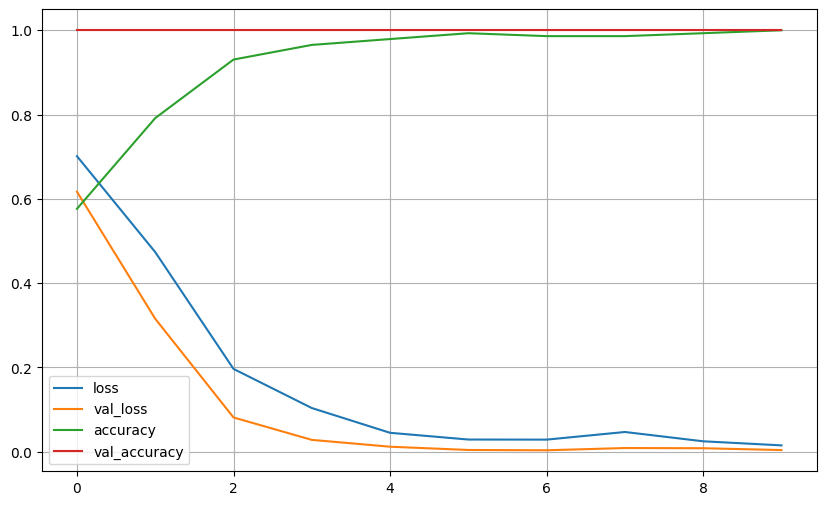

In [13]:
import matplotlib.pyplot as plt

plot_target = ['loss', 'val_loss', 'accuracy', 'val_accuracy']
plt.figure(figsize=(10, 6))

for each in plot_target:
    plt.plot(hist.history[each], label=each)

plt.legend()
plt.grid()
plt.show()

In [14]:
score = model.evaluate(X_test, y_test)
print('Test loss: ', score[0])
print('Test accuracy: ', score[1])

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 0.0042 
Test loss:  0.004124881699681282
Test accuracy:  1.0


##### 메모리 비움

In [4]:
import tensorflow as tf

tf.keras.backend.clear_session()

----------------------------------------

# 전체 폴더로 다루기

## 각 동영상에서 가능한 모든 프레임 추출하고 정제하기

In [5]:
import os
import cv2
import numpy as np
import pandas as pd

def extract_all_frames_with_labels(subject_dir, subject_num, target_frame_count=None):
    frames_list = []
    labels_list = []

    # Subject 폴더 내부의 Fall 및 ADL 폴더 탐색
    for activity in ['Fall', 'ADL']:
        activity_dir = os.path.join(subject_dir, activity)  # ADL 또는 Fall 폴더 경로
        csv_file = os.path.join(subject_dir, f'sub{subject_num}_{activity.lower()}.csv')  # 해당하는 CSV 파일 경로
        
        # CSV 파일 로드
        csv_data = pd.read_csv(csv_file)
        
        # 각 비디오 파일에 대해 프레임 추출 및 라벨링
        for video_file in os.listdir(activity_dir):
            if video_file.endswith('.mp4'):
                video_path = os.path.join(activity_dir, video_file)
                frames, frame_labels = extract_labeled_frames_with_time(video_path, csv_data, target_frame_count)
                
                # 출력: 총 프레임 수 및 라벨이 있는 프레임 수
                total_frames = len(frames)
                labeled_frames = len([label for label in frame_labels if label != 'Unknown'])
                print(f"{video_file}: 총 {total_frames}개의 프레임이 추출됨, 라벨이 있는 프레임 수: {labeled_frames}")
                
                # 모든 프레임과 라벨을 리스트에 추가
                frames_list.extend(frames)
                labels_list.extend(frame_labels)
    
    return np.array(frames_list), np.array(labels_list)

def extract_labeled_frames_with_time(video_path, csv_data, target_frame_count=None):
    cap = cv2.VideoCapture(video_path)
    frames = []
    labels = []

    # 비디오 파일 이름에 해당하는 CSV 데이터 필터링
    video_data = csv_data[csv_data['fileName'] == os.path.basename(video_path)]
    
    # 비디오에서 프레임 추출
    frame_rate = cap.get(cv2.CAP_PROP_FPS)  # 초당 프레임 수
    total_frames_in_video = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))  # 비디오의 총 프레임 수
    
    # 필요한 프레임 수 결정 (target_frame_count가 지정되지 않으면 전체 프레임 사용)
    if target_frame_count is None:
        target_frame_count = total_frames_in_video

    for _ in range(total_frames_in_video):
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.resize(frame, (64, 64))
        frames.append(frame)
        
        # 현재 프레임에 해당하는 시간 계산
        current_frame = len(frames) - 1
        current_time = current_frame / frame_rate
        
        # 현재 시간에 해당하는 라벨 찾기
        label = 'Unknown'
        for _, row in video_data.iterrows():
            start_time = row['startTime']
            end_time = row['endTime']
            if start_time <= current_time <= end_time:
                label = row['classes']
                break
        labels.append(label)

    cap.release()

    # 프레임 수 조정: 패딩 또는 샘플링
    frames, labels = adjust_frame_count(frames, labels, target_frame_count)

    # 정규화: 픽셀 값을 0과 1 사이로 정규화
    frames = np.array(frames) / 255.0
    return frames, labels

def adjust_frame_count(frames, labels, target_frame_count):
    current_frame_count = len(frames)

    if current_frame_count < target_frame_count:
        # 프레임이 부족한 경우: 패딩
        padding = target_frame_count - current_frame_count
        frames = np.pad(frames, ((0, padding), (0, 0), (0, 0), (0, 0)), mode='edge')
        labels.extend([labels[-1]] * padding)
    elif current_frame_count > target_frame_count:
        # 프레임이 많은 경우: 균일한 간격으로 샘플링
        indices = np.linspace(0, current_frame_count - 1, target_frame_count, dtype=int)
        frames = [frames[i] for i in indices]
        labels = [labels[i] for i in indices]

    return frames, labels

# 모든 Subject 폴더 처리
base_dir = './data/pose_est/origin_dataset'
X_data = []
y_data = []
for i, subject in enumerate(['Subject_1', 'Subject_2', 'Subject_3', 'Subject_4'], start=1):
    subject_dir = os.path.join(base_dir, subject)
    frames, labels = extract_all_frames_with_labels(subject_dir, subject_num=i)
    X_data.extend(frames)
    y_data.extend(labels)

# 데이터 변환
X_data = np.array(X_data)
y_data = np.array(y_data)

print(f"총 {len(X_data)}개의 프레임이 추출됨")
print(f"X_data shape: {X_data.shape}")
print(f"y_data shape: {y_data.shape}")


Sub1_09.mp4: 총 131개의 프레임이 추출됨, 라벨이 있는 프레임 수: 114
Sub1_10.mp4: 총 133개의 프레임이 추출됨, 라벨이 있는 프레임 수: 119
Sub1_01.mp4: 총 203개의 프레임이 추출됨, 라벨이 있는 프레임 수: 178
Sub1_06.mp4: 총 169개의 프레임이 추출됨, 라벨이 있는 프레임 수: 146
Sub1_16.mp4: 총 181개의 프레임이 추출됨, 라벨이 있는 프레임 수: 179
Sub1_07.mp4: 총 153개의 프레임이 추출됨, 라벨이 있는 프레임 수: 146
Sub1_03.mp4: 총 176개의 프레임이 추출됨, 라벨이 있는 프레임 수: 149
Sub1_14.mp4: 총 169개의 프레임이 추출됨, 라벨이 있는 프레임 수: 146
Sub1_15.mp4: 총 178개의 프레임이 추출됨, 라벨이 있는 프레임 수: 178
Sub1_08.mp4: 총 129개의 프레임이 추출됨, 라벨이 있는 프레임 수: 119
Sub1_02.mp4: 총 189개의 프레임이 추출됨, 라벨이 있는 프레임 수: 179
Sub1_13.mp4: 총 128개의 프레임이 추출됨, 라벨이 있는 프레임 수: 116
Sub1_12.mp4: 총 200개의 프레임이 추출됨, 라벨이 있는 프레임 수: 173
Sub1_05.mp4: 총 174개의 프레임이 추출됨, 라벨이 있는 프레임 수: 149
Sub1_04.mp4: 총 146개의 프레임이 추출됨, 라벨이 있는 프레임 수: 115
Sub1_11.mp4: 총 181개의 프레임이 추출됨, 라벨이 있는 프레임 수: 179
Sub1_adl_16.mp4: 총 104개의 프레임이 추출됨, 라벨이 있는 프레임 수: 89
Sub1_adl_07.mp4: 총 224개의 프레임이 추출됨, 라벨이 있는 프레임 수: 209
Sub1_adl_06.mp4: 총 364개의 프레임이 추출됨, 라벨이 있는 프레임 수: 328
Sub1_adl_12.mp4: 총 218개의 프레임이 추출됨, 라벨이 있는 프레임 수: 209
Sub1_

In [6]:
print(y_data.shape)

(34172,)


### Label Encoding & One-hot encoding

In [7]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

# 라벨을 숫자로 변환 (Label Encoding)
label_encoder = LabelEncoder()
numeric_labels = label_encoder.fit_transform(y_data)

# 원핫 인코딩 적용
one_hot_labels = to_categorical(numeric_labels, num_classes=len(label_encoder.classes_))

# y_data 업데이트
y_data = one_hot_labels

# 변환 후 데이터의 모양 확인
print(f"변환된 y_data shape: {y_data.shape}")  # 예: (34172, num_classes)
print(f"라벨 인코딩 클래스: {label_encoder.classes_}")


변환된 y_data shape: (34172, 10)
라벨 인코딩 클래스: ['Drinking' 'Eating' 'Exercising' 'Falling' 'Reading' 'Sitting' 'Sleeping'
 'Standing' 'Unknown' 'Walking']


In [8]:
print(X_data.dtype)

float64


### 데이터 분할 및 타입 변경

In [9]:
from sklearn.model_selection import train_test_split

# 데이터 타입 변경 (정규화 및 float32 변환)
X_data = X_data.astype('float32')
y_data = y_data.astype('float32')

# 데이터셋을 학습용과 테스트용으로 분리하기
X_train, X_test, y_train, y_test = train_test_split(
    X_data, y_data, test_size=0.2, random_state=42
)

# 분리된 데이터셋의 모양 출력
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

# 데이터 타입 확인
print(f"X_train dtype: {X_train.dtype}")
print(f"y_train dtype: {y_train.dtype}")


X_train shape: (27337, 64, 64, 3)
X_test shape: (6835, 64, 64, 3)
y_train shape: (27337, 10)
y_test shape: (6835, 10)
X_train dtype: float32
y_train dtype: float32


In [10]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

def build_conv2d_model(input_shape=(64, 64, 3), num_classes=10):  # num_classes를 10으로 설정
    model = Sequential()

    # 첫 번째 2D 합성곱 및 풀링 레이어
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))


    # 두 번째 2D 합성곱 및 풀링 레이어
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    # 세 번째 2D 합성곱 및 풀링 레이어
    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    # 평탄화 및 전결합 레이어
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.4))

    # 출력 레이어 (다중 클래스 분류)
    model.add(Dense(num_classes, activation='softmax'))

    # 모델 컴파일
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# 모델 생성
num_classes = y_data.shape[1]  # y_data의 두 번째 차원이 클래스의 개수이므로 10으로 설정됨
model = build_conv2d_model(input_shape=(64, 64, 3), num_classes=num_classes)

# 모델 요약 출력
model.summary()


/home/jook/venv/ml_venv/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2024-09-17 18:25:36.390548: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_INVALID_DEVICE: invalid device ordinal
2024-09-17 18:25:36.390593: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:135] retrieving CUDA diagnostic information for host: jookdesk
2024-09-17 18:25:36.390603: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:142] hostname: jookdesk
2024-09-17 18:25:36.390665: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:166] libcuda reported version is: 535.183.1
2024-09-17 18:25:36.390697: I external/local_xla/xla/stream_ex

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       589,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 684,490 (2.61 MB)

 Trainable params: 684,490 (2.61 MB)

 Non-trainable params: 0 (0.00 B)

### 모델 학습

In [11]:
# 모델 학습
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/50


2024-09-17 18:25:44.876662: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1343668224 exceeds 10% of free system memory.


853/855 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.4177 - loss: 1.6719

2024-09-17 18:26:12.789627: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 335953920 exceeds 10% of free system memory.


855/855 ━━━━━━━━━━━━━━━━━━━━ 29s 33ms/step - accuracy: 0.4182 - loss: 1.6705 - val_accuracy: 0.7718 - val_loss: 0.6511
Epoch 2/50
855/855 ━━━━━━━━━━━━━━━━━━━━ 27s 32ms/step - accuracy: 0.7288 - loss: 0.7835 - val_accuracy: 0.8372 - val_loss: 0.4718
Epoch 3/50
855/855 ━━━━━━━━━━━━━━━━━━━━ 27s 31ms/step - accuracy: 0.7863 - loss: 0.6136 - val_accuracy: 0.8677 - val_loss: 0.3787
Epoch 4/50
855/855 ━━━━━━━━━━━━━━━━━━━━ 27s 31ms/step - accuracy: 0.8190 - loss: 0.5252 - val_accuracy: 0.8859 - val_loss: 0.3322
Epoch 5/50
855/855 ━━━━━━━━━━━━━━━━━━━━ 27s 31ms/step - accuracy: 0.8379 - loss: 0.4635 - val_accuracy: 0.8942 - val_loss: 0.3029
Epoch 6/50
855/855 ━━━━━━━━━━━━━━━━━━━━ 27s 31ms/step - accuracy: 0.8512 - loss: 0.4273 - val_accuracy: 0.9030 - val_loss: 0.2711
Epoch 7/50
855/855 ━━━━━━━━━━━━━━━━━━━━ 27s 31ms/step - accuracy: 0.8651 - loss: 0.3922 - val_accuracy: 0.9075 - val_loss: 0.2570
Epoch 8/50
855/855 ━━━━━━━━━━━━━━━━━━━━ 27s 31ms/step - accuracy: 0.8694 - loss: 0.3744 - val_accurac

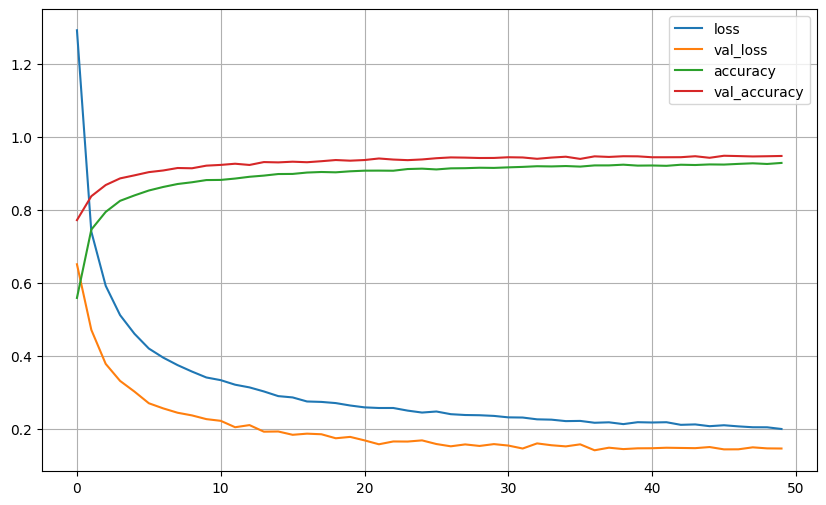

In [12]:
import matplotlib.pyplot as plt

plot_target = ['loss', 'val_loss', 'accuracy', 'val_accuracy']
plt.figure(figsize=(10, 6))

for each in plot_target:
    plt.plot(history.history[each], label=each)

plt.legend()
plt.grid()
plt.show()

In [13]:
score = model.evaluate(X_test, y_test)
print('Test loss: ', score[0])
print('Test accuracy: ', score[1])

 15/214 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9262 - loss: 0.2016

2024-09-17 19:14:08.275621: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 335953920 exceeds 10% of free system memory.


214/214 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9426 - loss: 0.1573
Test loss:  0.14733442664146423
Test accuracy:  0.9471836090087891


### 모델 저장

In [14]:
# 새로운 Keras 형식으로 모델 저장
model.save('fall_detection_model.keras')

# from keras.models import load_model

# # .keras 형식으로 저장된 모델 불러오기
# loaded_model = load_model('fall_detection_model.keras')


# Movenet

In [15]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow_docs.vis import embed
import numpy as np
import cv2
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import matplotlib.patches as patches

import imageio
from IPython.display import HTML, display

In [16]:
KEYPOINT_DICT = {
    'nose': 0,
    'left_eye': 1,
    'right_eye': 2,
    'left_ear': 3,
    'right_ear': 4,
    'left_shoulder': 5,
    'right_shoulder': 6,
    'left_elbow': 7,
    'right_elbow': 8,
    'left_wrist': 9,
    'right_wrist': 10,
    'left_hip': 11,
    'right_hip': 12,
    'left_knee': 13,
    'right_knee': 14,
    'left_ankle': 15,
    'right_ankle': 16
}

# Maps bones to a matplotlib color name.
KEYPOINT_EDGE_INDS_TO_COLOR = {
    (0, 1): 'm',
    (0, 2): 'c',
    (1, 3): 'm',
    (2, 4): 'c',
    (0, 5): 'm',
    (0, 6): 'c',
    (5, 7): 'm',
    (7, 9): 'm',
    (6, 8): 'c',
    (8, 10): 'c',
    (5, 6): 'y',
    (5, 11): 'm',
    (6, 12): 'c',
    (11, 12): 'y',
    (11, 13): 'm',
    (13, 15): 'm',
    (12, 14): 'c',
    (14, 16): 'c'
}
# KEYPOINT_EDGE_INDS_TO_COLOR = {
#     (0, 1): (255, 0, 255),
#     (0, 2): (0, 255, 255),
#     (1, 3): (255, 0, 255),
#     (2, 4): (0, 255, 255),
#     (0, 5): (255, 0, 255),
#     (0, 6): (0, 255, 255),
#     (5, 7): (255, 0, 255),
#     (7, 9): (255, 0, 255),
#     (6, 8): (0, 255, 255),
#     (8, 10): (0, 255, 255),
#     (5, 6): (0, 255, 0),
#     (5, 11): (255, 0, 255),
#     (6, 12): (0, 255, 255),
#     (11, 12): (0, 255, 0),
#     (11, 13): (255, 0, 255),
#     (13, 15): (255, 0, 255),
#     (12, 14): (0, 255, 255),
#     (14, 16): (0, 255, 255)
# }

def _keypoints_and_edges_for_display(keypoints_with_scores,
                                     height,
                                     width,
                                     keypoint_threshold=0.11):
  """Returns high confidence keypoints and edges for visualization.

  Args:
    keypoints_with_scores: A numpy array with shape [1, 1, 17, 3] representing
      the keypoint coordinates and scores returned from the MoveNet model.
    height: height of the image in pixels.
    width: width of the image in pixels.
    keypoint_threshold: minimum confidence score for a keypoint to be
      visualized.

  Returns:
    A (keypoints_xy, edges_xy, edge_colors) containing:
      * the coordinates of all keypoints of all detected entities;
      * the coordinates of all skeleton edges of all detected entities;
      * the colors in which the edges should be plotted.
  """
  keypoints_all = []
  keypoint_edges_all = []
  edge_colors = []
  num_instances, _, _, _ = keypoints_with_scores.shape
  for idx in range(num_instances):
    kpts_x = keypoints_with_scores[0, idx, :, 1]
    kpts_y = keypoints_with_scores[0, idx, :, 0]
    kpts_scores = keypoints_with_scores[0, idx, :, 2]
    kpts_absolute_xy = np.stack(
        [width * np.array(kpts_x), height * np.array(kpts_y)], axis=-1)
    kpts_above_thresh_absolute = kpts_absolute_xy[
        kpts_scores > keypoint_threshold, :]
    keypoints_all.append(kpts_above_thresh_absolute)

    for edge_pair, color in KEYPOINT_EDGE_INDS_TO_COLOR.items():
      if (kpts_scores[edge_pair[0]] > keypoint_threshold and
          kpts_scores[edge_pair[1]] > keypoint_threshold):
        x_start = kpts_absolute_xy[edge_pair[0], 0]
        y_start = kpts_absolute_xy[edge_pair[0], 1]
        x_end = kpts_absolute_xy[edge_pair[1], 0]
        y_end = kpts_absolute_xy[edge_pair[1], 1]
        line_seg = np.array([[x_start, y_start], [x_end, y_end]])
        keypoint_edges_all.append(line_seg)
        edge_colors.append(color)
  if keypoints_all:
    keypoints_xy = np.concatenate(keypoints_all, axis=0)
  else:
    keypoints_xy = np.zeros((0, 17, 2))

  if keypoint_edges_all:
    edges_xy = np.stack(keypoint_edges_all, axis=0)
  else:
    edges_xy = np.zeros((0, 2, 2))
  return keypoints_xy, edges_xy, edge_colors


def draw_prediction_on_image(
    image, keypoints_with_scores, crop_region=None, close_figure=False,
    output_image_height=None):
  """Draws the keypoint predictions on image.

  Args:
    image: A numpy array with shape [height, width, channel] representing the
      pixel values of the input image.
    keypoints_with_scores: A numpy array with shape [1, 1, 17, 3] representing
      the keypoint coordinates and scores returned from the MoveNet model.
    crop_region: A dictionary that defines the coordinates of the bounding box
      of the crop region in normalized coordinates (see the init_crop_region
      function below for more detail). If provided, this function will also
      draw the bounding box on the image.
    output_image_height: An integer indicating the height of the output image.
      Note that the image aspect ratio will be the same as the input image.

  Returns:
    A numpy array with shape [out_height, out_width, channel] representing the
    image overlaid with keypoint predictions.
  """
  height, width, channel = image.shape
  aspect_ratio = float(width) / height
  fig, ax = plt.subplots(figsize=(12 * aspect_ratio, 12))
  # To remove the huge white borders
  fig.tight_layout(pad=0)
  ax.margins(0)
  ax.set_yticklabels([])
  ax.set_xticklabels([])
  plt.axis('off')

  im = ax.imshow(image)
  line_segments = LineCollection([], linewidths=(4), linestyle='solid')
  ax.add_collection(line_segments)
  # Turn off tick labels
  scat = ax.scatter([], [], s=60, color='#FF1493', zorder=3)

  (keypoint_locs, keypoint_edges,
   edge_colors) = _keypoints_and_edges_for_display(
       keypoints_with_scores, height, width)

  line_segments.set_segments(keypoint_edges)
  line_segments.set_color(edge_colors)
  if keypoint_edges.shape[0]:
    line_segments.set_segments(keypoint_edges)
    line_segments.set_color(edge_colors)
  if keypoint_locs.shape[0]:
    scat.set_offsets(keypoint_locs)

  if crop_region is not None:
    xmin = max(crop_region['x_min'] * width, 0.0)
    ymin = max(crop_region['y_min'] * height, 0.0)
    rec_width = min(crop_region['x_max'], 0.99) * width - xmin
    rec_height = min(crop_region['y_max'], 0.99) * height - ymin
    rect = patches.Rectangle(
        (xmin,ymin),rec_width,rec_height,
        linewidth=1,edgecolor='b',facecolor='none')
    ax.add_patch(rect)

  fig.canvas.draw()
  image_from_plot = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
  image_from_plot = image_from_plot.reshape(
      fig.canvas.get_width_height()[::-1] + (3,))
  plt.close(fig)
  if output_image_height is not None:
    output_image_width = int(output_image_height / height * width)
    image_from_plot = cv2.resize(
        image_from_plot, dsize=(output_image_width, output_image_height),
         interpolation=cv2.INTER_CUBIC)
  return image_from_plot

def to_gif(images, fps):
  """Converts image sequence (4D numpy array) to gif."""
  imageio.mimsave('./animation.gif', images, fps=fps)
  return embed.embed_file('./animation.gif')

def progress(value, max=100):
  return HTML("""
      <progress
          value='{value}'
          max='{max}',
          style='width: 100%'
      >
          {value}
      </progress>
  """.format(value=value, max=max))

In [17]:

model_name = "movenet_lightning_f16" #@param ["movenet_lightning", "movenet_thunder", "movenet_lightning_f16.tflite", "movenet_thunder_f16.tflite", "movenet_lightning_int8.tflite", "movenet_thunder_int8.tflite"]

if "tflite" in model_name:
  if "movenet_lightning_f16" in model_name:
    !wget -q -O model.tflite https://tfhub.dev/google/lite-model/movenet/singlepose/lightning/tflite/float16/4?lite-format=tflite
    input_size = 192
  elif "movenet_thunder_f16" in model_name:
    !wget -q -O model.tflite https://tfhub.dev/google/lite-model/movenet/singlepose/thunder/tflite/float16/4?lite-format=tflite
    input_size = 256
  elif "movenet_lightning_int8" in model_name:
    !wget -q -O model.tflite https://tfhub.dev/google/lite-model/movenet/singlepose/lightning/tflite/int8/4?lite-format=tflite
    input_size = 192
  elif "movenet_thunder_int8" in model_name:
    !wget -q -O model.tflite https://tfhub.dev/google/lite-model/movenet/singlepose/thunder/tflite/int8/4?lite-format=tflite
    input_size = 256
  else:
    raise ValueError("Unsupported model name: %s" % model_name)

  # Initialize the TFLite interpreter
  interpreter = tf.lite.Interpreter(model_path="model.tflite")
  interpreter.allocate_tensors()

  def movenet(input_image):
    """Runs detection on an input image.

    Args:
      input_image: A [1, height, width, 3] tensor represents the input image
        pixels. Note that the height/width should already be resized and match the
        expected input resolution of the model before passing into this function.

    Returns:
      A [1, 1, 17, 3] float numpy array representing the predicted keypoint
      coordinates and scores.
    """
    # TF Lite format expects tensor type of uint8.
    input_image = tf.cast(input_image, dtype=tf.uint8)
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()
    interpreter.set_tensor(input_details[0]['index'], input_image.numpy())
    # Invoke inference.
    interpreter.invoke()
    # Get the model prediction.
    keypoints_with_scores = interpreter.get_tensor(output_details[0]['index'])
    return keypoints_with_scores

else:
  if "movenet_lightning" in model_name:
    module = hub.load("https://tfhub.dev/google/movenet/singlepose/lightning/4")
    input_size = 192
  elif "movenet_thunder" in model_name:
    module = hub.load("https://tfhub.dev/google/movenet/singlepose/thunder/4")
    input_size = 256
  else:
    raise ValueError("Unsupported model name: %s" % model_name)

  def movenet(input_image):
    """Runs detection on an input image.

    Args:
      input_image: A [1, height, width, 3] tensor represents the input image
        pixels. Note that the height/width should already be resized and match the
        expected input resolution of the model before passing into this function.

    Returns:
      A [1, 1, 17, 3] float numpy array representing the predicted keypoint
      coordinates and scores.
    """
    model = module.signatures['serving_default']

    # SavedModel format expects tensor type of int32.
    input_image = tf.cast(input_image, dtype=tf.int32)
    # Run model inference.
    outputs = model(input_image)
    # Output is a [1, 1, 17, 3] tensor.
    keypoints_with_scores = outputs['output_0'].numpy()
    return keypoints_with_scores

In [18]:
#@title Cropping Algorithm

# Confidence score to determine whether a keypoint prediction is reliable.
MIN_CROP_KEYPOINT_SCORE = 0.2

def init_crop_region(image_height, image_width):
  """Defines the default crop region.

  The function provides the initial crop region (pads the full image from both
  sides to make it a square image) when the algorithm cannot reliably determine
  the crop region from the previous frame.
  """
  if image_width > image_height:
    box_height = image_width / image_height
    box_width = 1.0
    y_min = (image_height / 2 - image_width / 2) / image_height
    x_min = 0.0
  else:
    box_height = 1.0
    box_width = image_height / image_width
    y_min = 0.0
    x_min = (image_width / 2 - image_height / 2) / image_width

  return {
    'y_min': y_min,
    'x_min': x_min,
    'y_max': y_min + box_height,
    'x_max': x_min + box_width,
    'height': box_height,
    'width': box_width
  }

def torso_visible(keypoints):
  """Checks whether there are enough torso keypoints.

  This function checks whether the model is confident at predicting one of the
  shoulders/hips which is required to determine a good crop region.
  """
  return ((keypoints[0, 0, KEYPOINT_DICT['left_hip'], 2] >
           MIN_CROP_KEYPOINT_SCORE or
          keypoints[0, 0, KEYPOINT_DICT['right_hip'], 2] >
           MIN_CROP_KEYPOINT_SCORE) and
          (keypoints[0, 0, KEYPOINT_DICT['left_shoulder'], 2] >
           MIN_CROP_KEYPOINT_SCORE or
          keypoints[0, 0, KEYPOINT_DICT['right_shoulder'], 2] >
           MIN_CROP_KEYPOINT_SCORE))

def determine_torso_and_body_range(
    keypoints, target_keypoints, center_y, center_x):
  """Calculates the maximum distance from each keypoints to the center location.

  The function returns the maximum distances from the two sets of keypoints:
  full 17 keypoints and 4 torso keypoints. The returned information will be
  used to determine the crop size. See determineCropRegion for more detail.
  """
  torso_joints = ['left_shoulder', 'right_shoulder', 'left_hip', 'right_hip']
  max_torso_yrange = 0.0
  max_torso_xrange = 0.0
  for joint in torso_joints:
    dist_y = abs(center_y - target_keypoints[joint][0])
    dist_x = abs(center_x - target_keypoints[joint][1])
    if dist_y > max_torso_yrange:
      max_torso_yrange = dist_y
    if dist_x > max_torso_xrange:
      max_torso_xrange = dist_x

  max_body_yrange = 0.0
  max_body_xrange = 0.0
  for joint in KEYPOINT_DICT.keys():
    if keypoints[0, 0, KEYPOINT_DICT[joint], 2] < MIN_CROP_KEYPOINT_SCORE:
      continue
    dist_y = abs(center_y - target_keypoints[joint][0]);
    dist_x = abs(center_x - target_keypoints[joint][1]);
    if dist_y > max_body_yrange:
      max_body_yrange = dist_y

    if dist_x > max_body_xrange:
      max_body_xrange = dist_x

  return [max_torso_yrange, max_torso_xrange, max_body_yrange, max_body_xrange]

def determine_crop_region(
      keypoints, image_height,
      image_width):
  """Determines the region to crop the image for the model to run inference on.

  The algorithm uses the detected joints from the previous frame to estimate
  the square region that encloses the full body of the target person and
  centers at the midpoint of two hip joints. The crop size is determined by
  the distances between each joints and the center point.
  When the model is not confident with the four torso joint predictions, the
  function returns a default crop which is the full image padded to square.
  """
  target_keypoints = {}
  for joint in KEYPOINT_DICT.keys():
    target_keypoints[joint] = [
      keypoints[0, 0, KEYPOINT_DICT[joint], 0] * image_height,
      keypoints[0, 0, KEYPOINT_DICT[joint], 1] * image_width
    ]

  if torso_visible(keypoints):
    center_y = (target_keypoints['left_hip'][0] +
                target_keypoints['right_hip'][0]) / 2;
    center_x = (target_keypoints['left_hip'][1] +
                target_keypoints['right_hip'][1]) / 2;

    (max_torso_yrange, max_torso_xrange,
      max_body_yrange, max_body_xrange) = determine_torso_and_body_range(
          keypoints, target_keypoints, center_y, center_x)

    crop_length_half = np.amax(
        [max_torso_xrange * 1.9, max_torso_yrange * 1.9,
          max_body_yrange * 1.2, max_body_xrange * 1.2])

    tmp = np.array(
        [center_x, image_width - center_x, center_y, image_height - center_y])
    crop_length_half = np.amin(
        [crop_length_half, np.amax(tmp)]);

    crop_corner = [center_y - crop_length_half, center_x - crop_length_half];

    if crop_length_half > max(image_width, image_height) / 2:
      return init_crop_region(image_height, image_width)
    else:
      crop_length = crop_length_half * 2;
      return {
        'y_min': crop_corner[0] / image_height,
        'x_min': crop_corner[1] / image_width,
        'y_max': (crop_corner[0] + crop_length) / image_height,
        'x_max': (crop_corner[1] + crop_length) / image_width,
        'height': (crop_corner[0] + crop_length) / image_height -
            crop_corner[0] / image_height,
        'width': (crop_corner[1] + crop_length) / image_width -
            crop_corner[1] / image_width
      }
  else:
    return init_crop_region(image_height, image_width)

def crop_and_resize(image, crop_region, crop_size):
  """Crops and resize the image to prepare for the model input."""
  boxes=[[crop_region['y_min'], crop_region['x_min'],
          crop_region['y_max'], crop_region['x_max']]]
  output_image = tf.image.crop_and_resize(
      image, box_indices=[0], boxes=boxes, crop_size=crop_size)
  return output_image

def run_inference(movenet, image, crop_region, crop_size):
  """Runs model inferece on the cropped region.

  The function runs the model inference on the cropped region and updates the
  model output to the original image coordinate system.
  """
  image_height, image_width, _ = image.shape
  input_image = crop_and_resize(
    tf.expand_dims(image, axis=0), crop_region, crop_size=crop_size)
  # Run model inference.
  keypoints_with_scores = movenet(input_image)
  # Update the coordinates.
  for idx in range(17):
    keypoints_with_scores[0, 0, idx, 0] = (
        crop_region['y_min'] * image_height +
        crop_region['height'] * image_height *
        keypoints_with_scores[0, 0, idx, 0]) / image_height
    keypoints_with_scores[0, 0, idx, 1] = (
        crop_region['x_min'] * image_width +
        crop_region['width'] * image_width *
        keypoints_with_scores[0, 0, idx, 1]) / image_width
  return keypoints_with_scores

In [30]:
# def extract_features(keypoints_with_scores):
#     """관절 좌표를 기반으로 특징을 추출"""
#     keypoints = keypoints_with_scores[0, 0, :, :2]  # 각 프레임의 관절 좌표만 추출
#     keypoints = keypoints.flatten()
#     return keypoints

In [19]:
import numpy as np
import cv2

def extract_features_as_image(keypoints_with_scores, image_size=(64, 64)):
    """관절 좌표를 기반으로 특징 이미지를 생성"""
    # 빈 이미지를 생성 (검은 배경)
    feature_image = np.zeros((image_size[0], image_size[1], 3), dtype=np.uint8)

    # 각 keypoint를 이미지에 그리기
    for idx, keypoint in enumerate(keypoints_with_scores[0, 0, :, :2]):
        x, y = int(keypoint[1] * image_size[1]), int(keypoint[0] * image_size[0])
        # 이미지에 점 그리기
        cv2.circle(feature_image, (x, y), 2, (255, 255, 255), -1)  # 흰색 점

    return feature_image / 255.0  # Normalize to [0, 1] range

# Example usage:
# keypoints_with_scores = ...  # Movenet 결과
# features_as_image = extract_features_as_image(keypoints_with_scores)




## 탐지 - 동영상

In [29]:
import cv2
import numpy as np
import tensorflow as tf

def real_time_fall_detection_with_conv2d(video_path):
    cap = cv2.VideoCapture(video_path)
    # input_size = 192  # Movenet에 맞는 입력 크기 (예: 192)

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        image_height, image_width, _ = frame.shape
        crop_region = init_crop_region(image_height, image_width)
        
        # Movenet으로 관절 추출
        keypoints_with_scores = run_inference(movenet, frame, crop_region, crop_size=(input_size, input_size))
        
        # 관절을 특징 이미지로 변환
        features_as_image = extract_features_as_image(keypoints_with_scores)

        # 모델에 입력할 수 있는 형태로 변환
        # (64, 64) -> (64, 64, 1) -> (64, 64, 3)
        if len(features_as_image.shape) == 2:  # (64, 64) 모양일 경우
            features_as_image = np.stack((features_as_image,) * 3, axis=-1)  # (64, 64, 3)으로 변환
        
        features_as_image_expanded = np.expand_dims(features_as_image, axis=0)  # (1, 64, 64, 3)

        # 추락 여부 추측
        prediction = model.predict(features_as_image_expanded)
        predicted_class = np.argmax(prediction)  # 예측된 클래스
        
        # 추락 여부 확인 및 표시
        if predicted_class == label_encoder.transform(['Falling'])[0]:
            cv2.putText(frame, "Fall Detected!", (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)

        # 결과 프레임 보여주기
        cv2.imshow("Fall Detection", frame)
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    
    cap.release()
    cv2.destroyAllWindows()

# 사용 예시
real_time_fall_detection_with_conv2d("./data/pose_est/origin_dataset/Subject_3/ADL/Sub3_adl_22.mp4")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━

## 탐지 - 실시간

In [30]:
import cv2
import numpy as np

def real_time_fall_detection(video_source=0):
    cap = cv2.VideoCapture(video_source)
    input_size = 192  # Movenet에 맞는 입력 크기

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        image_height, image_width, _ = frame.shape
        crop_region = init_crop_region(image_height, image_width)
        keypoints_with_scores = run_inference(movenet, frame, crop_region, crop_size=(input_size, input_size))
        
        # 특징 추출: 이미지 형태로 변환 (64, 64)
        features_as_image = extract_features_as_image(keypoints_with_scores)

        # 모델이 기대하는 입력 형태로 변환
        if len(features_as_image.shape) == 2:  # (64, 64) 모양일 경우
            features_as_image = np.stack((features_as_image,) * 3, axis=-1)  # (64, 64, 3)으로 변환
        
        features_as_image_expanded = np.expand_dims(features_as_image, axis=0)  # (1, 64, 64, 3)

        # 추락 여부 추측
        prediction = model.predict(features_as_image_expanded)
        predicted_class = np.argmax(prediction)  # 예측된 클래스
        
        # 추락 여부 확인 및 표시
        if predicted_class == label_encoder.transform(['Falling'])[0]:
            cv2.putText(frame, "Fall Detected!", (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)

        # 결과 프레임 보여주기
        cv2.imshow("Fall Detection", frame)
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()

# 실시간 웹캠을 사용하여 추락 감지
real_time_fall_detection(0)  # 0은 기본 웹캠


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━